In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Inverting heat source')

In [3]:
import heatn as ht
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
import ipdb
import warnings
import time
warnings.filterwarnings("ignore")
N = 500
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)
D[-2,-1]=0
A,Sigma=ht.makeA_periodic(500,5)
u=ht.gensource(N=500,spikes=2,lim=40)
m=ht.meas(u,blur='gaussian')
#psnr=ht.getx(A,m,u,D)

In [4]:
store = ht.exp(trails=2)

spikes 2 trial: 0 psnr 28.787884813785073
spikes 2 trial: 1 psnr 37.59291573210219
spikes 4 trial: 0 psnr 30.28463222974931
spikes 4 trial: 1 psnr 30.82958014587726
spikes 6 trial: 0 psnr 26.71567265053017
spikes 6 trial: 1 psnr 42.88810702074542
spikes 8 trial: 0 psnr 25.708830026563117
spikes 8 trial: 1 psnr 22.065098831646523
spikes 10 trial: 0 psnr 20.681580938693433
spikes 10 trial: 1 psnr 35.95846162843127
spikes 12 trial: 0 psnr 18.30446618282148
spikes 12 trial: 1 psnr 26.3926695518879
spikes 14 trial: 0 psnr 30.524206911210598
spikes 14 trial: 1 psnr 27.074933009646486
spikes 16 trial: 0 psnr 36.00959244646848
spikes 16 trial: 1 psnr 24.32263031640147
spikes 18 trial: 0 psnr 23.526745425099644
spikes 18 trial: 1 psnr 37.21146899494027


In [8]:
mydict={}
mydict[5] = 10
max(mydict.values())

10

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7656238550>,
 [<matplotlib.lines.Line2D at 0x7f75e932a6d0>])

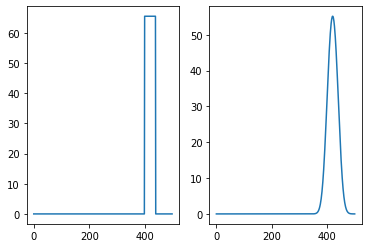

In [4]:
plt.subplot(121),plt.plot(u)
plt.subplot(122),plt.plot(m)

In [5]:
def myADMM(Sigma,y,constrain=True,maxit=3000,tol=1e-6,epsilon=1e0,rho=1):
  y = y.numpy()
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda = sp.sparse.diags(scipy.fft.fft(a),0)
  x =y#np.random.randn(N,)
  z = np.zeros(N,)#np.random.randn(N,)
  u = np.zeros(N,)#np.random.randn(N,)
  F = sp.fft.fft(np.eye(N))/np.sqrt(N)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda.conjugate()@Lambda).diagonal()
  invD = sp.sparse.diags(1/d,0)
  if constrain == True:
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      x = np.maximum(x,0)
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>50 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
  else: 
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda.conjugate()@sp.fft.fft(z-u).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      z = (abs(D1@x+u)>(1./rho))*(abs(D1@x+u)-1./rho)*np.sign(D1@x+u)
      u = u + D1@x - z
      err.append(np.linalg.norm(D1@x-z))
      if i>100 and np.linalg.norm(D1@x-z) < tol:
        print('iter',i)
        break
  return x

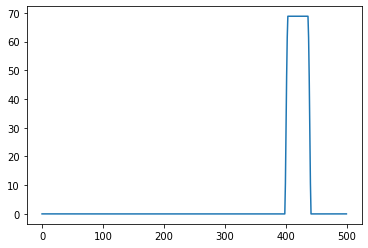

In [6]:
warnings.filterwarnings("ignore")
z = myADMM(Sigma**1100,m,constrain=True,maxit=300,tol=1e-6,epsilon=1e0,rho=1)
plt.plot(z)

In [7]:
def l1solv_mix(Fw1,meas,D,u):
# Create variable.
   x_l1 = cp.Variable(shape=(500,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D@x_l1, 1)+ cp.norm((Fw1.numpy()@x_l1)[:,0]-meas, 2)**2*1e0)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   mx_norm = torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 2))**2*5e-4
   #psnr_recon = psnr1(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value

In [8]:
x_cvx = l1solv_mix(torch.matrix_power(A, int(1100)),m,D,u)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f75e8d16ad0>,
 [<matplotlib.lines.Line2D at 0x7f75e047fe90>])

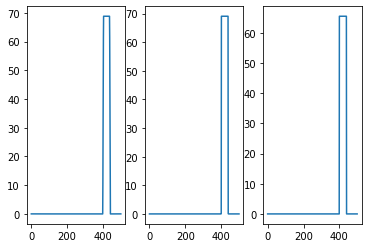

In [9]:
plt.subplot(131),plt.plot(z)
plt.subplot(132),plt.plot(x_cvx)
plt.subplot(133),plt.plot(u)

In [10]:
def psnr1(A,B):
    MSE = torch.mean((A-B)**2)**0.5
    return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)  

In [11]:
print(psnr1(torch.from_numpy(z),u))
print(psnr1(torch.from_numpy(x_cvx).reshape(N,),u))

tensor(28.0300, dtype=torch.float64)
tensor(24.2139, dtype=torch.float64)


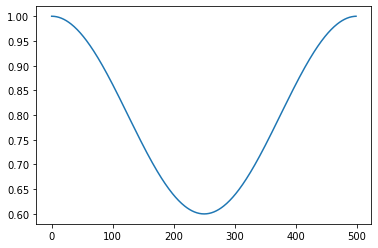

In [14]:
plt.plot(Sigma.toarray().diagonal())

In [17]:
psnr=ht.getx1(Sigma,m,u,D)
psnr

tensor(28.3251, dtype=torch.float64)

In [12]:
psnr1=ht.getx(A,m,u,D)
psnr1

psnr: tensor(20.6901, dtype=torch.float64)
psnr: tensor(21.2865, dtype=torch.float64)
psnr: tensor(21.2206, dtype=torch.float64)
psnr: tensor(21.5861, dtype=torch.float64)
psnr: tensor(21.4488, dtype=torch.float64)
psnr: tensor(22.4034, dtype=torch.float64)
psnr: tensor(24.4438, dtype=torch.float64)
psnr: tensor(28.5464, dtype=torch.float64)
psnr: tensor(27.7357, dtype=torch.float64)
psnr: tensor(24.5499, dtype=torch.float64)
psnr: tensor(22.4588, dtype=torch.float64)
psnr: tensor(21.2211, dtype=torch.float64)
psnr: tensor(20.2675, dtype=torch.float64)
psnr: tensor(20.3280, dtype=torch.float64)
psnr: tensor(20.4456, dtype=torch.float64)
psnr: tensor(20.8093, dtype=torch.float64)
psnr: tensor(20.7161, dtype=torch.float64)
psnr: tensor(20.6882, dtype=torch.float64)
psnr: tensor(20.3232, dtype=torch.float64)
psnr: tensor(19.8038, dtype=torch.float64)


tensor(27.7357, dtype=torch.float64)

In [ ]:
psnr2=ht.getx(A,m,u,D,power=1,epsilon=1e1)
psnr2

In [ ]:
psnr=ht.getx1(Sigma,m,u,D)

In [8]:
store = ht.exp()

NameError: ignored

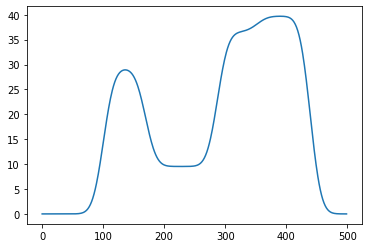

In [21]:
plt.plot(m)

In [31]:
store

array([[36.48758201, 43.72783889, 34.98154993, 29.60616155, 24.47372213,
        28.72919448, 30.56995144, 23.88754168, 27.55660028],
       [46.75070987, 39.62659684, 33.19727797, 26.60791321, 23.99043999,
        21.77061267, 25.06599865, 24.30022195, 19.3865539 ]])

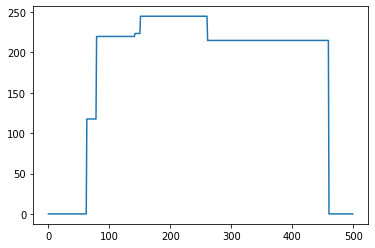

In [114]:
N = 500
lim =40
spikes = 5
u=torch.zeros((N,1))
k = np.random.randint(lim+10,N-lim-10,spikes)
u[k] = 50*torch.randn(spikes,1)
u = np.cumsum(u)
u[:lim] = 0                      
u[-lim:] = 0
u=abs(u)

plt.plot(u)